# Dijagnosticka klasifikacija raka dojke

Ucitavanje potrebnih biblioteka

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from scipy import stats


**1. Pocetno preprocesiranje podataka**

*Ucitavanje dataset-a*

In [13]:
# lista imena kolona
column_names = [
    "id",
    "diagnosis",    # ciljna promenljiva (B -> 0 ili M -> 1)
    "mean radius", 
    "mean texture", 
    "mean perimeter", 
    "mean area",
    "mean smoothness", 
    "mean compactness", 
    "mean concavity", 
    "mean concave points",
    "mean symmetry", 
    "mean fractal dimension",
    "radius se", 
    "texture se", 
    "perimeter se", 
    "area se",
    "smoothness se", 
    "compactness se", 
    "concavity se", 
    "concave points se",
    "symmetry se", 
    "fractal dimension se",
    "worst radius", 
    "worst texture", 
    "worst perimeter", 
    "worst area",
    "worst smoothness", 
    "worst compactness", 
    "worst concavity", 
    "worst concave points",
    "worst symmetry", 
    "worst fractal dimension"
]

# učitavanje sa imenima kolona
df = pd.read_csv("data.csv", names=column_names)

*Ciscenje i pocetna analiza*

In [14]:
# mapiranje B -> 0, M -> 1
df["diagnosis"] = df["diagnosis"].map({"B": 0, "M": 1}) 

# Provera nedostajucih vrednosti
print("\nNedostajuce vrednosti po kolonama:\n", df.isnull().sum())

# Uklanjanje atributa koji ocigledno ne uticu na izlaz
if 'id' in df.columns:
    df = df.drop(columns=['id'])

print("\nPrvih 5 redova:\n", df.head())
print("\nBroj uzoraka po klasama:\n", df["diagnosis"].value_counts())
df.info()


Nedostajuce vrednosti po kolonama:
 id                         0
diagnosis                  0
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius se                  0
texture se                 0
perimeter se               0
area se                    0
smoothness se              0
compactness se             0
concavity se               0
concave points se          0
symmetry se                0
fractal dimension se       0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

Prvih 5 redova:
    d

*Detekcija i uklanjanje anomalija*

In [15]:
def remove_outliers_zscore(df, threshold=3):
    """
    Uklanja anomalije iz DataFrame-a na osnovu Z-score metode.
    """
    z_scores = stats.zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < threshold).all(axis=1)
    return df[filtered_entries]

# Uklanjanje anomalija iz DataFrame-a
df_no_outliers = remove_outliers_zscore(df, threshold=3)

print("Originalni oblik skupa podataka:", df.shape)
print("Oblik skupa podataka nakon uklanjanja anomalija:", df_no_outliers.shape)

# Ponovna podela podataka na setove (koristeći novi DataFrame)
X = df_no_outliers.drop('diagnosis', axis=1)
y = df_no_outliers['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Originalni oblik skupa podataka: (569, 31)
Oblik skupa podataka nakon uklanjanja anomalija: (495, 31)


**2. Eksplorativna analiza skupa**

*Analiza i prikaz korelacije*

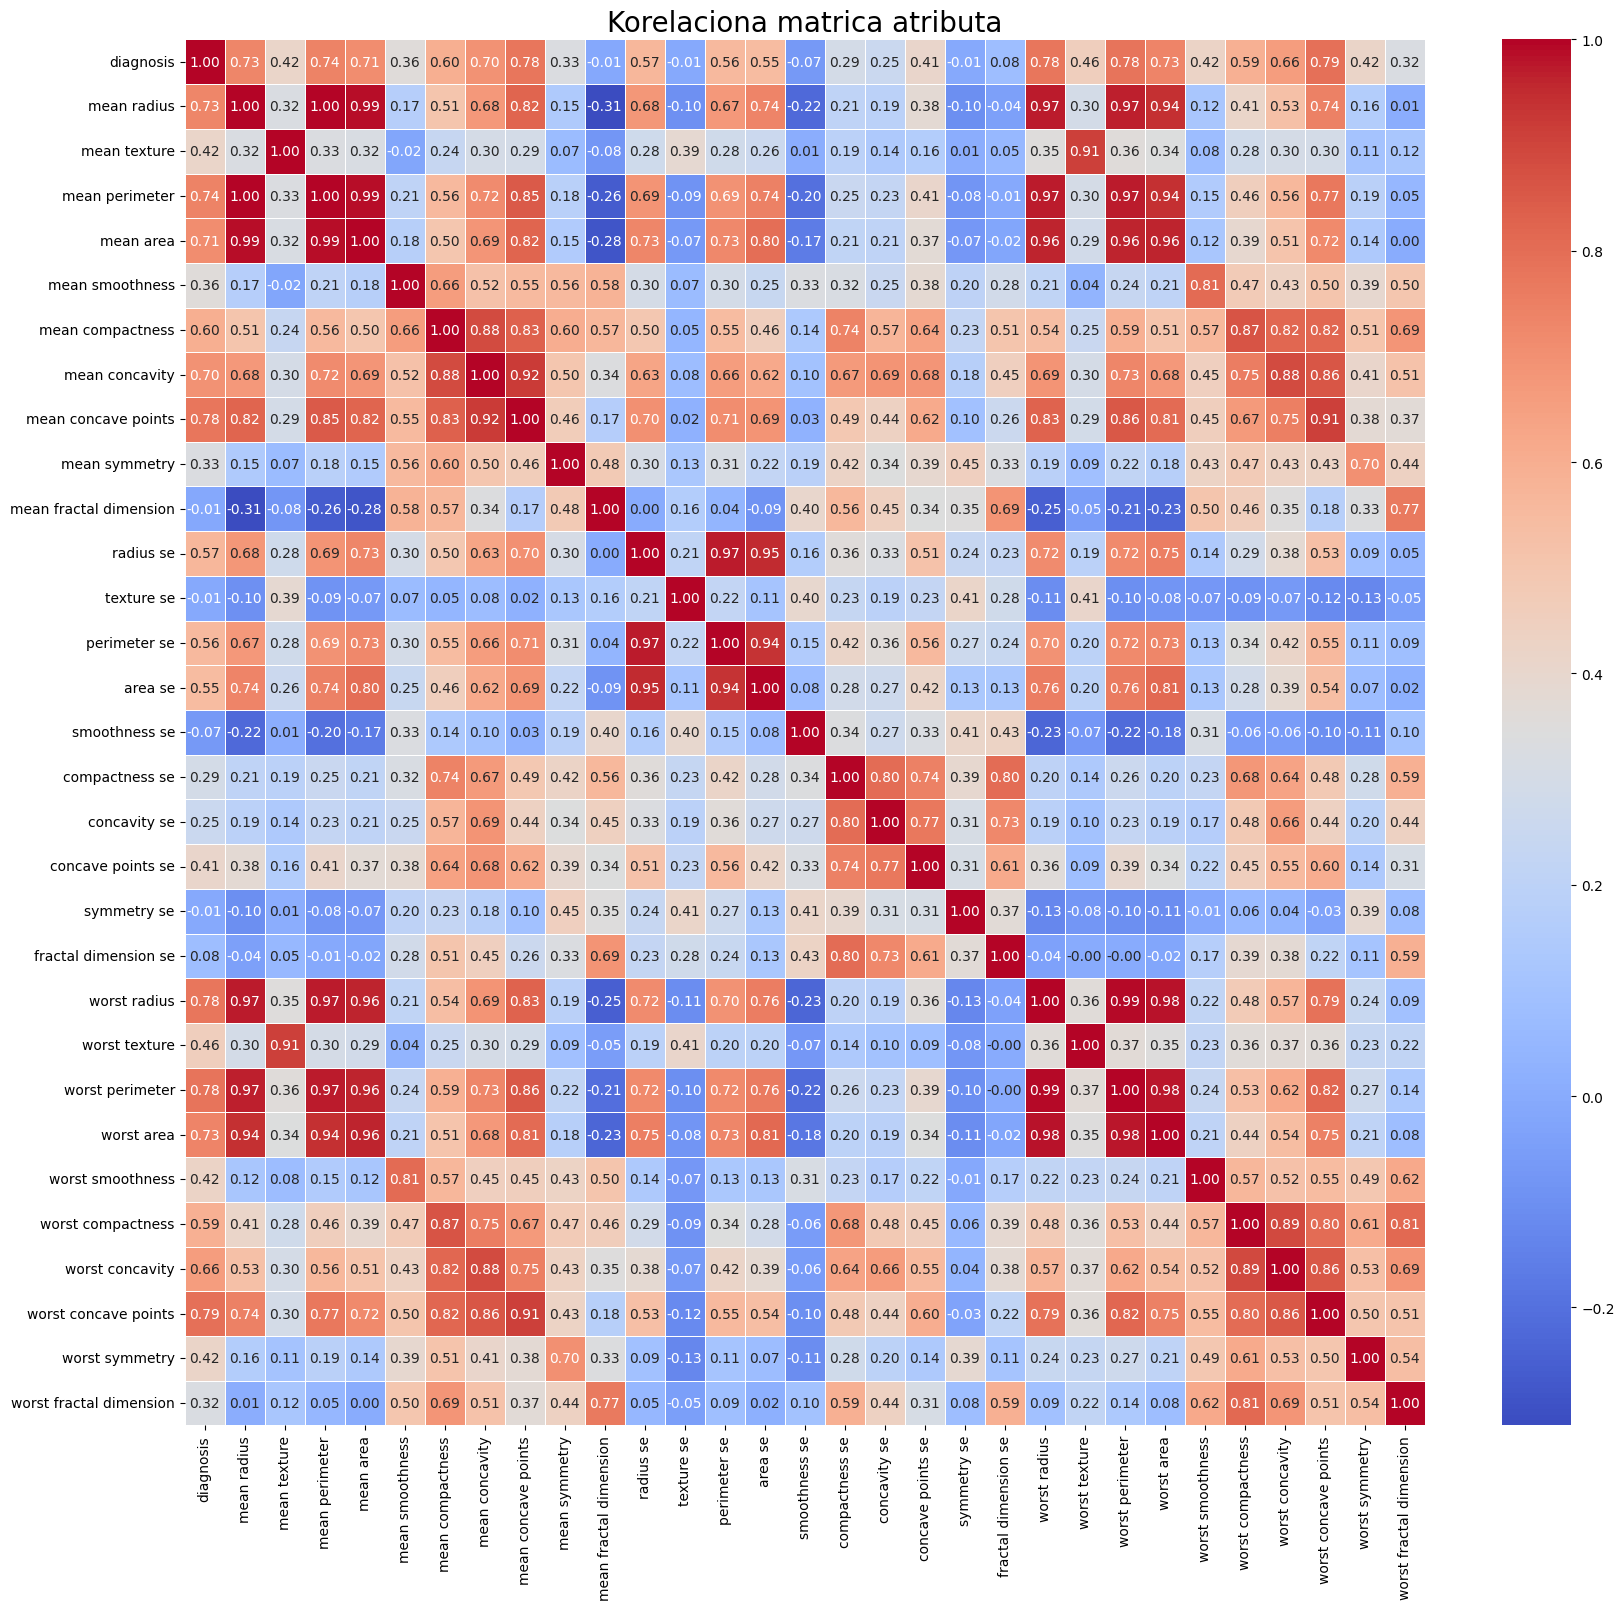

In [16]:
correlation_matrix = df.corr()

# Vizualizacija korelacione matrice
plt.figure(figsize=(20, 18))
sbn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korelaciona matrica atributa', fontsize=20)
plt.show()


**3. Odabir i treniranje modela**

*Odabir atributa i setova*

In [24]:
# Odvajanje atributa (X) i ciljne promenljive (y)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Podela podataka na trening (80%) i test (20%) set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Oblik trening skupa: {X_train.shape}")
print(f"Oblik test skupa: {X_test.shape}")

# Skaliranje atributa (obavezno za LR, SVM, KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

predictions = {}
models = {}
performance_metrics = {}

Oblik trening skupa: (455, 30)
Oblik test skupa: (114, 30)


**Trening modela**

Logisticka regresija

In [25]:
print("\n--- Optimizacija modela: Logisticka Regresija ---")

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42), 
    param_grid=param_grid_lr, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

grid_search_lr.fit(X_train_scaled, y_train)

best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_scaled)
predictions['Logisticka Regresija (Optimizovana)'] = y_pred_lr
models['Logisticka Regresija (Optimizovana)'] = best_lr

print(f"Najbolji parametri za Logisticku Regresiju: {grid_search_lr.best_params_}")
print(f"Tacnost na test podacima: {accuracy_score(y_test, y_pred_lr):.4f}")


--- Optimizacija modela: Logisticka Regresija ---
Najbolji parametri za Logisticku Regresiju: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Tacnost na test podacima: 0.9825


Slucajna suma

In [26]:
print("\n--- Optimizacija modela: Slucajna suma ---")

param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid_rf, 
    cv=5, 
    scoring="accuracy", 
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
predictions['Slucajna suma (Optimizovana)'] = y_pred_rf
models['Slucajna suma (Optimizovana)'] = best_rf

print(f"Najbolji parametri za Slucajnu sumu: {grid_search_rf.best_params_}")
print(f"Tacnost na test podacima sa optimizovanim Random Forest modelom: {accuracy_score(y_test, y_pred_rf):.4f}")


--- Optimizacija modela: Slucajna suma ---
Najbolji parametri za Slucajnu sumu: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Tacnost na test podacima sa optimizovanim Random Forest modelom: 0.9737


KNN

In [27]:
print("\n--- Optimizacija modela: KNN ---")

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid=param_grid_knn, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

grid_search_knn.fit(X_train_scaled, y_train)

best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
predictions['KNN (Optimizovan)'] = y_pred_knn
models['KNN (Optimizovan)'] = best_knn

print(f"Najbolji parametri za KNN: {grid_search_knn.best_params_}")
print(f"Tacnost na test podacima sa optimizovanim KNN modelom: {accuracy_score(y_test, y_pred_knn):.4f}")


--- Optimizacija modela: KNN ---
Najbolji parametri za KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Tacnost na test podacima sa optimizovanim KNN modelom: 0.9386


SVM

In [28]:
print("\n--- Optimizacija modela: SVM ---")

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}

grid_search_svm = GridSearchCV(
    estimator=SVC(random_state=42), 
    param_grid=param_grid_svm, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

grid_search_svm.fit(X_train_scaled, y_train)

best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
predictions['SVM (Optimizovan)'] = y_pred_svm
models['SVM (Optimizovan)'] = best_svm

print(f"Najbolji parametri za SVM: {grid_search_svm.best_params_}")
print(f"Tacnost na test podacima sa optimizovanim SVM modelom: {accuracy_score(y_test, y_pred_svm):.4f}")


--- Optimizacija modela: SVM ---
Najbolji parametri za SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Tacnost na test podacima sa optimizovanim SVM modelom: 0.9737


***Uporedjivanje preformanis***


 Rezultati i poredjenje modela:


--- Model: Logisticka Regresija (Optimizovana) ---


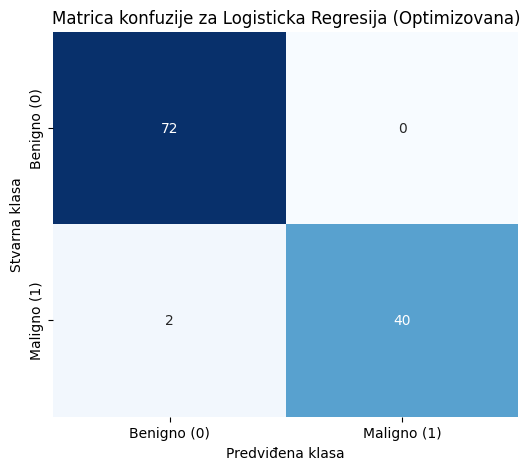

Izvestaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


--- Model: Slucajna suma (Optimizovana) ---


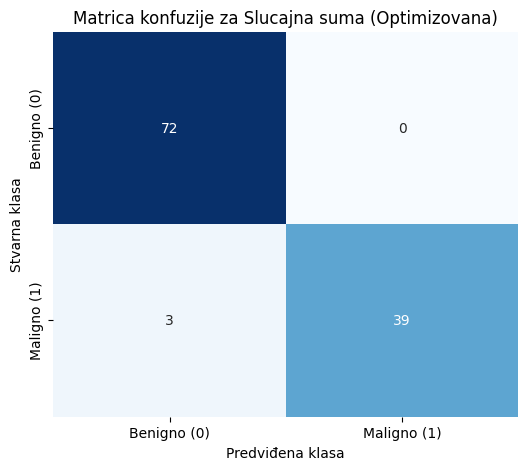

Izvestaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114


--- Model: KNN (Optimizovan) ---


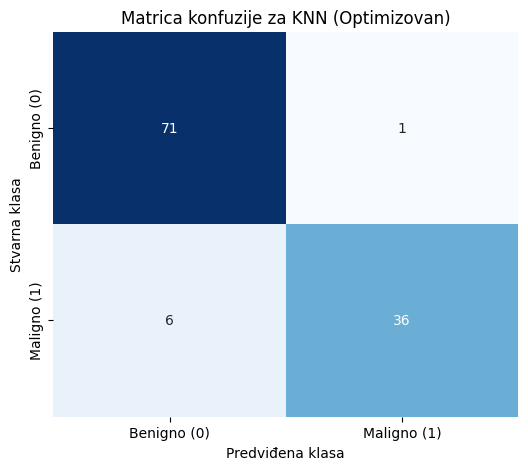

Izvestaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        72
           1       0.97      0.86      0.91        42

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114


--- Model: SVM (Optimizovan) ---


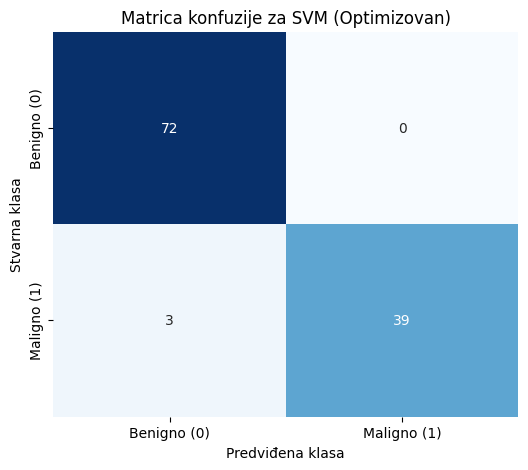

Izvestaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [29]:
print("\n Rezultati i poredjenje modela:\n")

for model_name, y_pred in predictions.items():
    print(f"\n--- Model: {model_name} ---")
    
    # Računanje metrika i čuvanje za tabelu
    performance_metrics[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

    # Matrica konfuzije
    cm = confusion_matrix(y_test, y_pred)
    
    # Prikaz matrice konfuzije
    plt.figure(figsize=(6, 5))
    sbn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Benigno (0)', 'Maligno (1)'],
                yticklabels=['Benigno (0)', 'Maligno (1)'])
    plt.xlabel('Predviđena klasa')
    plt.ylabel('Stvarna klasa')
    plt.title(f'Matrica konfuzije za {model_name}')
    plt.show()
    
    # Prikaz izveštaja o klasifikaciji
    print("Izvestaj o klasifikaciji:")
    print(classification_report(y_test, y_pred))

***Analiza i tumacenje rezultata***

--- Tabela performansi svih modela ---

                                     Accuracy  Precision  Recall  F1-Score
Logisticka Regresija (Optimizovana)    0.9825     1.0000  0.9524    0.9756
Slucajna suma (Optimizovana)           0.9737     1.0000  0.9286    0.9630
KNN (Optimizovan)                      0.9386     0.9730  0.8571    0.9114
SVM (Optimizovan)                      0.9737     1.0000  0.9286    0.9630


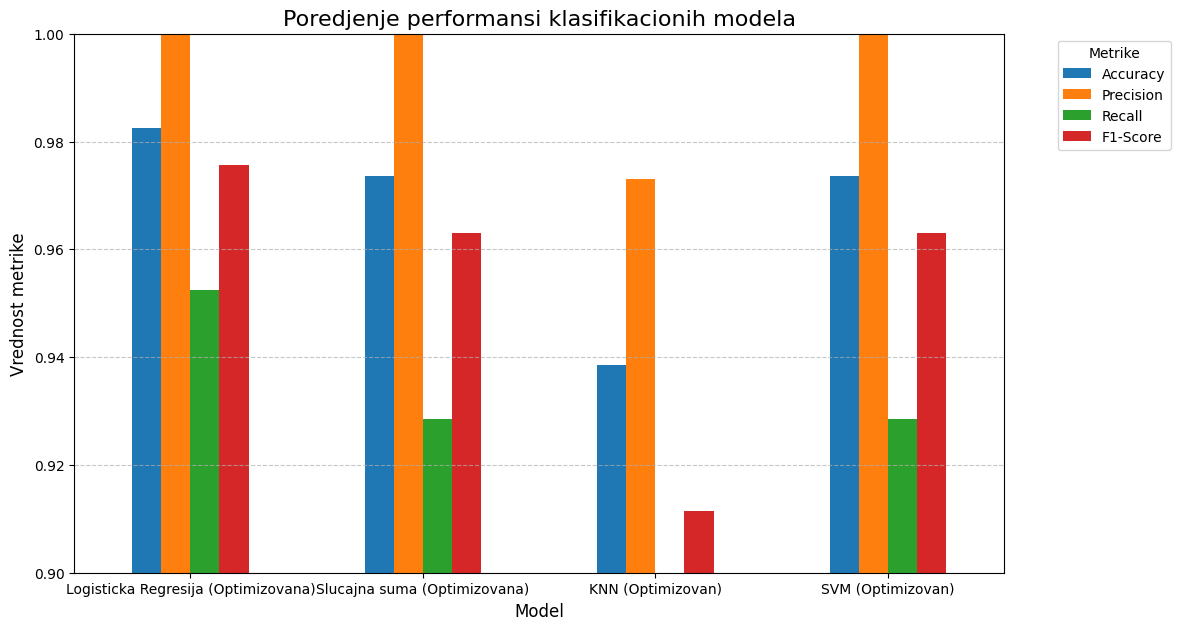


--- 10 najvažnijih atributa prema optimizovanom modelu Slučajne šume ---

             Atribut  Vaznost
worst concave points   0.1100
 mean concave points   0.1042
          worst area   0.1029
        worst radius   0.0994
      mean perimeter   0.0831
     worst perimeter   0.0775
         mean radius   0.0628
           mean area   0.0488
      mean concavity   0.0481
     worst concavity   0.0461


C:\Users\Srdjan\AppData\Local\Temp\ipykernel_3872\3010288007.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sbn.barplot(x='Vaznost', y='Atribut', data=feature_importances_tuned.head(10), palette='viridis')


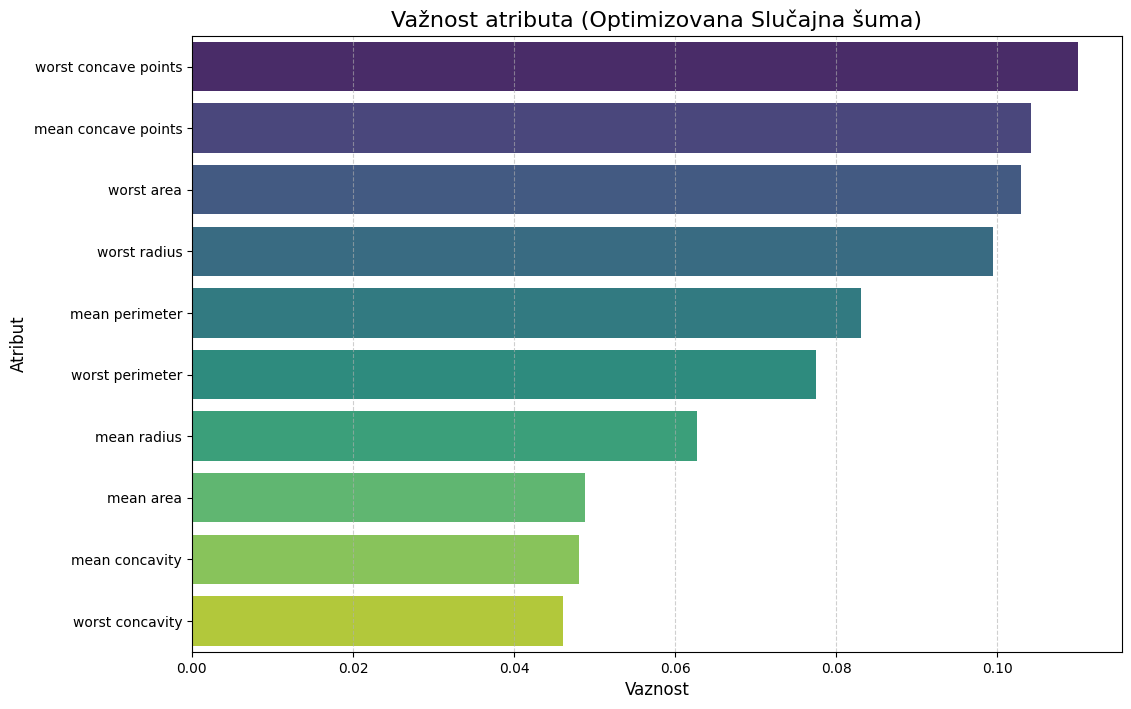

In [31]:
# Prikaz tabela performansi (ponovo)
metrics_df = pd.DataFrame(performance_metrics).T
print("--- Tabela performansi svih modela ---\n")
print(metrics_df.to_string(float_format="%.4f"))

# Vizualizacija metrika (ponovo)
metrics_df.plot(kind='bar', figsize=(12, 7), rot=0)
plt.title('Poredjenje performansi klasifikacionih modela', fontsize=16)
plt.ylabel('Vrednost metrike', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0.9, 1.0)
plt.legend(title='Metrike', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Ponovna analiza važnosti atributa sa optimizovanim Random Forest modelom
rf_model_tuned = models['Slucajna suma (Optimizovana)']
feature_importances_tuned = pd.DataFrame({
    'Atribut': X.columns,
    'Vaznost': rf_model_tuned.feature_importances_
}).sort_values(by='Vaznost', ascending=False)

print("\n--- 10 najvažnijih atributa prema optimizovanom modelu Slučajne šume ---\n")
print(feature_importances_tuned.head(10).to_string(index=False, float_format="%.4f"))

# Vizualizacija najvažnijih atributa (ponovo)
plt.figure(figsize=(12, 8))
sbn.barplot(x='Vaznost', y='Atribut', data=feature_importances_tuned.head(10), palette='viridis')
plt.title('Važnost atributa (Optimizovana Slučajna šuma)', fontsize=16)
plt.xlabel('Vaznost', fontsize=12)
plt.ylabel('Atribut', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()